In [1]:
#Import Packages
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import camb 
from camb import model, initialpower
import glob
import pylab as plty
from PIL import Image

%matplotlib inline


ImportError: cannot import name 'compiler' from 'tensorflow.python.autograph.pyct' (/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/__init__.py)

In [ ]:
def basicgenmap(_strt, _stop, _NSIDE):  # (start, stop, NSIDE)
    '''
    Generate a basic map which is just an array with element values which are increasing from a 'start' to a 'stop'.
    '''
    _NPIX = 12*_NSIDE**2 #The number of pixels in a map, NPIX = 12*(NSIDE)^2
    return   np.linspace(_strt,_stop,_NPIX)        #generates an array in the 'ring' scheme


In [ ]:
#Use CAMB to generate a power spectrum
def call_CAMB_map(_parameters, _lmax): #lmax above 2551 makes no difference?
    '''
    parameters = [H0, ombh2, omch2, mnu, omk, tau]  = [Hubble Const, Baryon density, DM density, 
    Sum 3 neutrino masses/eV, Curvature parameter (Omega kappa), Reionisation optical depth]
    '''
    if _lmax <= 2551: #can only find power spectrum for lmax <= 2551 since that is the maximum value of the data.
        pars = camb.CAMBparams()
        pars.set_cosmology(H0 = _parameters[0], ombh2 = _parameters[1], omch2 = _parameters[2], mnu = _parameters[3],
                   omk = _parameters[4], tau = _parameters[5])  #Inputs the given cosmological parameters.
        pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        
        pars.set_for_lmax(_lmax, lens_potential_accuracy=0) #input the given lmax value
        
        results = camb.get_results(pars)
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK') #returns the power spectrum in units muK.
        
        totCL=powers['total'] #returns the total (averaged) power spectrum - including lensed, unlensed power spectra 
        _DL = totCL[:,0] 
        
        #unlensedCL=powers['unlensed_scalar'] #returns the unlensed scalar power spectrum
        #_DL = unlensedCL[:,0] # 
    
        _l = np.arange(len(_DL)) #not sure this CL is actually CL but is actually DL
        _CL = []
        for i in range(_lmax): #also limits the length of power spectrum to the requested length
            if i == 0:
                _CL.append(_DL[i]) #since unsure what CL value is for this DL
        
            else:
                _CL.append(_DL[i]/(_l[i]*(_l[i] + 1)))
        
        _CL = np.array(_CL)    
    
        return _CL 
    
    else: #prints error if lmax is too large.
        print('lmax value is larger than the available data.')

In [ ]:
#Plots a given power spectrum 
def plotpwrspctrm(_cls):
    _l = np.arange(len(_cls))
    plt.plot(_l, _l * (_l + 1) * _cls)
    plt.xlabel("$\l$")
    plt.ylabel("$\l(\l+1)C_{\l}$")
    plt.grid()
    plt.title("Power Spectrum")

#PLots a map in the mollview projection 
def mollviewmap(_map):
    hp.mollview(_map, title="Map displayed in the Aithoff projection", cmap = None)
    hp.graticule()


In [ ]:
#Adds random noise to each pixel on a map given a variance 
def noisemapfunc(_map,_var):
    _noisevec = np.random.normal(0,_var,len(_map))
    _newmap = [x + y for x, y in zip(_map, _noisevec)]
    _newmap, _noisevec = np.array(_newmap), np.array(_noisevec)
    return [_newmap, _noisevec] #returns an array consisiting of [map with added noise, array of the added noise]


In [ ]:
#cls --> something
def cltoalm(_cls, _NSIDE): #does this manually - doesn't work
    _alms = []
    _lmax = (3*_NSIDE)
    _count = 0
    for l in range(_lmax): 
        if _cls[l] > 0:
            _alms.append(np.complex(np.random.normal(0,_cls[l]),0))        #set m=0, which is real
        else:
            _alms.append(np.complex(0,0))
        
        for m in range(l): #set positive m's
            if _cls[l] > 0 and _cls[m] > 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),np.random.normal(0,0.5*_cls[m])))
            if _cls[l] > 0 and _cls[m] <= 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),0))
            if _cls[l] <= 0 and _cls[m] > 0:
                _alms.append(np.complex(0,np.random.normal(0,0.5*_cls[m])))
            else:
                _alms.append(np.complex(0,0))
    
    return _alms   

def hpcltoalm(_cls, _NSIDE): #Healpy generate alms given cls
    return hp.synalm(_cls, lmax = (3*_NSIDE) - 1, new = True)

def cltomap(_cls, _NSIDE):
    _alm = cltoalm(_cls, _NSIDE)
    return almtomap(_alm, _NSIDE)

def hpcltomap(_cls, _NSIDE):   #Healpy generate a map given a power spectrum
    return hp.synfast(_cls, _NSIDE, new=True)   #pixwin=False, fwhm=np.radians(7.0),


In [ ]:
#map --> something
def maptocl(_map):
    return

def hpmaptocl(_map): #Generate a power spectrum given cls
    return hp.anafast(_map, lmax=int(((3*(len(_map)/12)**0.5)-1)))    #lmax = 3NSIDE -1 by default

def maptoalm(_map):
    _omegp = (4*np.pi)/len(_map)
    _lmax = int(np.sqrt(len(_map)*(3/4)))
    _NSIDE = int(_lmax/3)
    _alm = []
    for l in range(_lmax):
        for m in range(l+1):
            _TpYlm = []
            for i in range(len(_map)):
                _TpYlm.append(_map[i]*np.conjugate(sphharm(m, l, i, _NSIDE)))
                    
            _alm.append(_omegp*sum(_TpYlm))
    
    return _alm


def hpmaptoalm(_map, _lmax): #Healpy generate alms from map. 
    return hp.map2alm(_map, _lmax)


In [ ]:
#alm --> something
def almtocl(_alm,lmax): #not the same value as healpy
    _l = np.arange(lmax)
    _scaling = 1 / ((2*_l + 1))
    count = 0
    _new = []
    _cl = []
    for l in range(lmax):
        _new.append([])
        for m in range(l):
            if m == 0:
                _new[l].append(np.absolute(_alm[count])**2)
                count = count + 1
                
            if m > 0:
                _new[l].append(2*np.absolute(_alm[count])**2)
                count = count + 1
              
    for i in range(len(_new)):
        _cl.append(_scaling[i] * sum(_new[i]))
    
    return _cl

def hpalmtocl(_alms, _lmax): #Healpy estimates the power spectrum from the cls.
    return hp.alm2cl(_alms, lmax = _lmax)

def almtomap(_alm, _NSIDE ):# alm --> map 
    _map = []
    _Npix = 12*(_NSIDE)**2
    _lmax = (3*_NSIDE)

    for i in range(_Npix):
        _sum = []
        _count = 0
        for l in np.arange(0,_lmax):
            for m in np.arange(0,l+1):
                if m == 0:
                    _sum.append(_alm[_count]*sphharm(m,l,i, _NSIDE))
                    _count = _count + 1
                else:
                    _sum.append(2*(np.real(_alm[_count])*np.real(sphharm(m,l,i, _NSIDE)) -
                                   np.imag(_alm[_count])*np.imag(sphharm(m,l,i, _NSIDE))))
                    _count = _count + 1
        _map.append(sum(_sum))

    return np.real(_map)
    
    #else:
    #    print('Error: Map is Complex')
        



def almtomap_tf(_alm, _NSIDE): #alm --> map for tensorflow 
    _map = tf.constant([])
    _lmax = (3*_NSIDE)
    for i in range(12*(_NSIDE)**2):
        _sum = tf.constant([])
        _count = 0
        for l in range(_lmax):
            for m in range(l+1):
                if m==0:
                    _sum = tf.concat((_sum,[_alm[_count]*sphharm(m,l,i, _NSIDE)]), axis = 0)
                    _count = _count + 1
                else:
                    _sum = tf.concat((_sum,[2*((np.real(_alm[_count]))*(np.real(sphharm(m,l,i, _NSIDE)))-
                                               np.imag(_alm[_count])*np.imag(sphharm(m,l,i, _NSIDE)))]), axis = 0)
                    _count = _count + 1
        _map = tf.concat((_map,[sum(_sum)]), axis = 0)
    return tf.convert_to_tensor(_map)


def hpalmtomap(_alms, _NSIDE):
    return hp.alm2map(_alms, _NSIDE)

In [29]:
maptest1 = almtomap(noisealm4, NSIDE4)
print(maptest1)
#mollviewmap(maptest1)

maptest2 = hp.alm2map(noisealm4,NSIDE4)
print(maptest2)
#mollviewmap(maptest2)

abe = (1+2j)
print(np.imag(abe)) 

[ 13.26822757 -23.91875062 -23.91875062  13.26822757  47.85434263
 -14.62223326   6.58759262 -11.62505802 -11.62505802   6.58759262
 -14.62223326  47.85434263  14.11117778  24.06966643  -6.73108036
 -15.83813622  14.08213988 -15.83813622  -6.73108036  24.06966643
  28.98511427 -13.0370876    1.32492315  -5.90890391  -5.90890391
   1.32492315 -13.0370876   28.98511427  14.11117778  -2.3509152
   2.25428166  -3.32301137  14.08213988  -3.32301137   2.25428166
  -2.3509152   -5.76179355  -1.6987879    9.67649362   8.25473865
   8.25473865   9.67649362  -1.6987879   -5.76179355 -15.90771544
  14.14504985  14.14504985 -15.90771544]
[ -7.90868437   7.88730991  17.39620206   0.97950019  -0.12411467
  -3.29277662  19.24310226 -18.26996313   1.3427208   13.08881246
  -0.83708827  16.85514325   5.8002598  -16.20603229   9.10020459
  10.09403466 -11.52694042  -4.99480628   9.6720972  -13.02474683
 -13.71808251  -8.29204579  17.45577657  12.23512908  -9.7650449
   0.66877849   0.85481747 -19.496121

In [10]:
#healpy smoothing for the map and the alms
def hpmapsmooth(_map, _lmax): #smooths a given map with a gaussian beam smoother.
    return hp.smoothing(_map, lmax = _lmax)

def hpalmsmooth(_alms): #smooths a given set of alms with a gaussian beam smoother.
    return hp.smoothalm(_alms, fwhm = 0.0)
    

In [11]:
#splits/rejoins the alms into real/imaginary parts so that they can be optimised with scipy.optimize.minimize()
def singulartosplitalm(_alm):
    _realalm, _imagalm = _alm.real, _alm.imag
    return [_realalm, _imagalm]
    

def splittosingularalm(_realalm, _imagalm):
    _alm = []
    for i in range(len(_realalm)):
        _alm.append(complex(_realalm[i], _imagalm[i]))
    return _alm

def splittosingularalm_tf(_realalm, _imagalm): #takes the real and imaginary parts of the alms and creates a tensor
    return tf.complex(_realalm,_imagalm)

In [12]:
#Retrieves the spherical harmonics for a given, l, m and pixel number
def sphharm(m, l, _pixno, _NSIDE):
    _theta, _phi = hp.pix2ang(nside=_NSIDE, ipix=_pixno)
    return sp.special.sph_harm(m, l, _theta, _phi)
    

In [13]:
#negative log of the posterior, psi.
def psi(_params, _map, _lmax, _Ninv): #unnormalised log probability
    _lncl, _realalm, _imagalm = [], [], []
    
    for i in range(len_cl):
        _lncl.append(_params[i])
    for i in range(len_ralm):
        _realalm.append(_params[i + len_cl])
    for i in range(len_ialm):
        _imagalm.append(_params[i + len_cl + len_ralm])
    
    _d = _map
    _a = splittosingularalm(_realalm, _imagalm)
    _Ya = almtomap(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _elem, _term1, _term2, _psi1 ,_psi2, _psi3 = [], [], [], [], [], []
    _sum = 0
    
    for i in range(len(_d)):
        _elem.append(_d[i] - _BYa[i])
        _psi1.append(0.5*(_elem[i]**2)*_Ninv[i]) #first term in the taylor paper 
    
    _l = np.arange(_lmax)
    for i in range(len(_lncl)):
        _psi2.append((_l[i] + 0.5)*(_lncl[i]))
    
    
    for i in range(len(_lncl)):
        _term1.append([])
        for j in range(i+1):
            if j == _sum:
                _term1[i].append(np.absolute(_a[_sum])**2)
            else:
                _term1[i].append(2*np.absolute(_a[_sum])**2)
            _sum = _sum + 1
            if j == i:
                _term2.append(sum(_term1[i])) 
    for i in range(len(_lncl)):
        _psi3.append(_term2[i]/(2*np.exp(_lncl[i])))
    
        
    _psi = sum(_psi1) + sum(_psi2) + sum(_psi3) #third term in the taylor paper
    print('psi =',_psi)
    return _psi

In [ ]:
def multtensor(_lmax,_lenalm):
    _shape = np.zeros([_lmax,_lenalm]) #matrix for the calculation of the psi in psi_tf
    _count = 0
    for i in range(_lmax):
        for j in np.arange(0,i+1):
            if j == 0:
                _shape[i][_count] = 1.0
                _count = _count + 1
            else:
                _shape[i][_count] = 2.0
                _count = _count + 1
    return tf.convert_to_tensor(_shape, dtype = tf.float32)


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

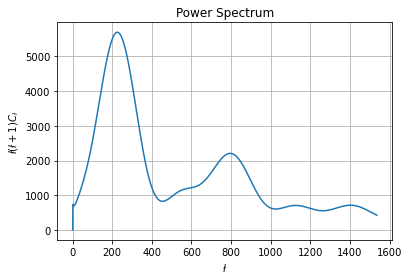

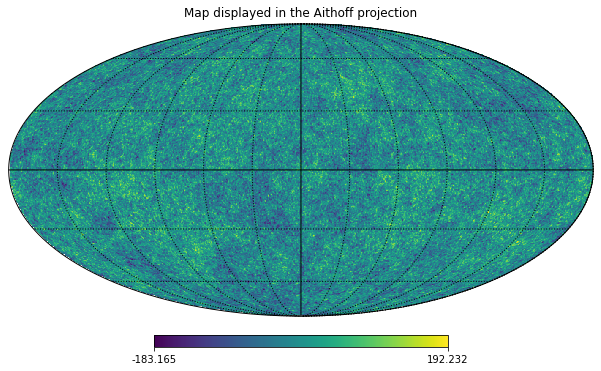

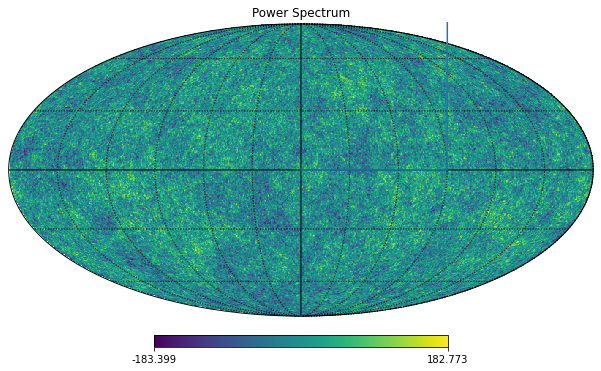

In [14]:
#Trial with parameters 1
parameters1 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax1 = 1536  #lmax value wanted from data
NSIDE1 = int(lmax1/3)  #len(cls1)/3   #3*nside = len(cls)
n1 = np.linspace(5,5,(12*(NSIDE1)**2))
Ninv1 = []
for i in range(len(n1)):
    Ninv1.append(1/(n1[i]**2)) #finds the inverse noise matrix

cls1 = call_CAMB_map(parameters1, lmax1) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls1) #plot of the power spectrum.
map1 = hpcltomap(cls1, NSIDE1)  #generates a map from the power spectrum
map1 = hpmapsmooth(map1, lmax1) #applies a gaussian beam smoother to the map
mollviewmap(map1) #plots the map
noisemap1 = noisemapfunc(list(map1),n1[0])[0] #adds noise to the map
mollviewmap(noisemap1) #plots the map with noise
alms1 = hpmaptoalm(noisemap1,lmax1) #computes the alms from the map with noise added.
CLestimate1 = hpalmtocl(alms1, lmax1) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate1) #plots the estimated power spectrum.


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

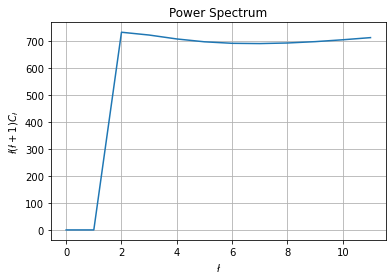

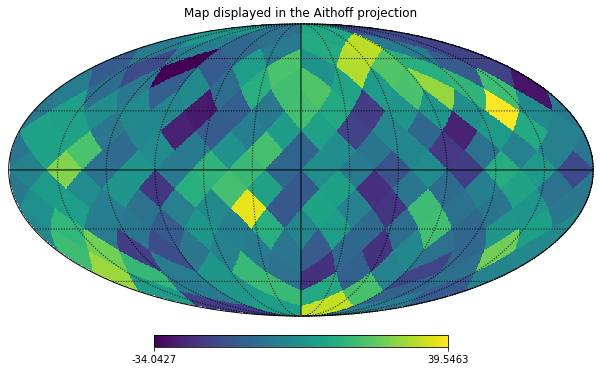

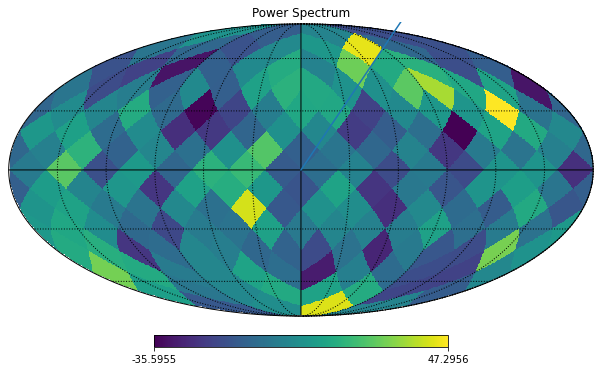

In [15]:
#Trial with parameters 2
parameters2 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax2 = 12   #lmax value wanted from data
NSIDE2 = int(lmax2/3)   #len(cls1)/3   #3*nside = len(cls)
n2 = np.linspace(5,5,(12*(NSIDE2)**2))
Ninv2 = []
for i in range(len(n2)):
    Ninv2.append(1/(n2[i]**2)) #finds the inverse noise matrix
    

cls2 = call_CAMB_map(parameters2, lmax2) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls2) #plot of the power spectrum.
map2 = hpcltomap(cls2, NSIDE2)  #generates a map from the power spectrum
map2 = hpmapsmooth(map2, lmax2) #applies a gaussian beam smoother to the map
mollviewmap(map2) #plots the map
noisemap2 = noisemapfunc(map2,n2[0])[0] #adds noise to the map
mollviewmap(noisemap2) #plots the map with noise
alms2 = hpmaptoalm(noisemap2,lmax2) #computes the alms from the map with noise added.
CLestimate2 = hpalmtocl(alms2, lmax2) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate2) #plots the estimated power spectrum.


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

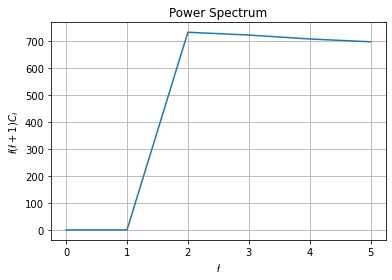

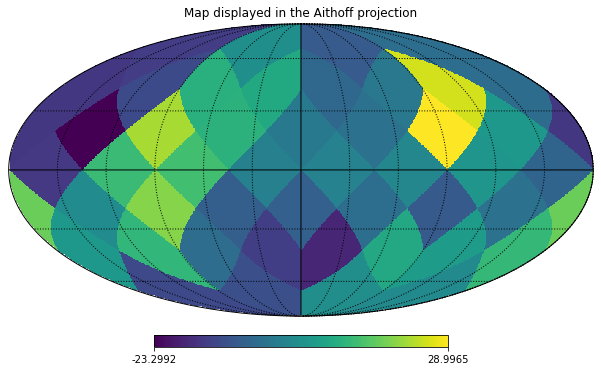

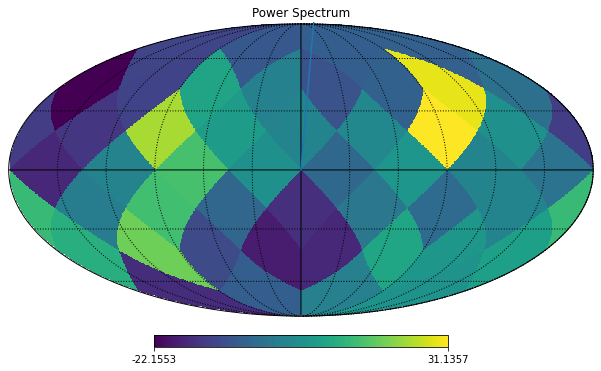

In [16]:
#Trial with parameters 3
parameters3 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax3 = 6  #lmax value wanted from data
NSIDE3 = int(lmax3/3)  #len(cls1)/3   #3*nside = len(cls)
n3 = np.linspace(5,5,(12*(NSIDE3)**2))
Ninv3 = []
for i in range(len(n3)):
    Ninv3.append(1/(n3[i]**2)) #finds the inverse noise matrix

cls3 = call_CAMB_map(parameters3, lmax3) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls3) #plot of the power spectrum.
map3 = hpcltomap(cls3, NSIDE3)  #generates a map from the power spectrum
map3 = hpmapsmooth(map3, lmax3) #applies a gaussian beam smoother to the map
mollviewmap(map3) #plots the map
noisemap3 = noisemapfunc(map3,n3[0])[0] #adds noise to the map
mollviewmap(noisemap3) #plots the map with noise
alms3 = hpmaptoalm(noisemap3,lmax3) #computes the alms from the map with noise added.
CLestimate3 = hpalmtocl(alms3, lmax3) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate3) #plots the estimated power spectrum.


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


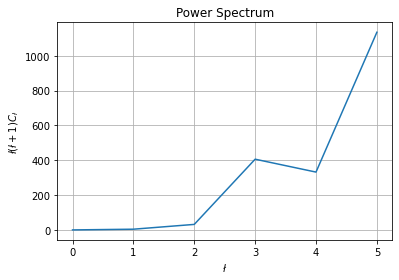

In [15]:
#Trial with parameters 4
parameters4 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax4 = 6  #lmax value wanted from data
NSIDE4 = int(lmax4/3)  #len(cls1)/3   #3*nside = len(cls)
n4 = np.linspace(5,5,(12*(NSIDE4)**2))
Ninv4 = []
for i in range(len(n4)):
    Ninv4.append(1/(n4[i]**2)) #finds the inverse noise matrix
    
cls4 = call_CAMB_map(parameters4, lmax4) #power spectrum for the given parameters and lmax.
map4 = hpcltomap(cls4, NSIDE4)  #generates a map from the power spectrum
map4 = hpmapsmooth(map4, lmax4) #applies a gaussian beam smoother to the map
noisemap4 = noisemapfunc(map4,n4[0])[0] #adds noise to the map

noisealm4 = np.array(maptoalm(noisemap4)) #recover cls from map
noisecl4 = almtocl(noisealm4, lmax4)
plotpwrspctrm(noisecl4) #plots the estimated power spectrum.


In [76]:
#inital values for the optimisation of psi (with the values from parameters4)
noisemap = noisemap4
clinit = noisecl4
realalminit = noisealm4.real
imagalminit = noisealm4.imag
x0 = []
len_cl = len(clinit)
len_ralm = len(realalminit)
len_ialm = len(imagalminit)
for i in range(len(clinit)):
    if clinit[i] > 0:
        x0.append(np.log(clinit[i]))
    else:
        x0.append(0)
for i in range(len(realalminit)):
    x0.append(realalminit[i])
for i in range(len(imagalminit)):
    x0.append(imagalminit[i])
print(x0)
print('psi_init = ',psi(x0,noisemap,lmax4,Ninv4))

[0, 0.39890702802761807, 1.5553420441972527, 2.8820166423008002, 3.235959012877552, 3.293276794912257, 2.11437584108803, 2.2930876548957744, -3.0340171765607677, 4.229674484910639, -0.08028746723664525, 0.05936345272252827, -1.3913714870192362, 6.129132950829871, -4.607794315837178, 7.05640300439498, 12.164690369182097, -2.462082341482375, 1.107474311713906, 2.6598259293272215, -2.5376747579371277, 3.5500200806855564, 7.884509598402735, -1.8937552964556417, -1.2196425825707666, -1.1457170792997002, -0.8287905048234552, 0.0, 0.0, 0.08590869245813847, 0.0, 3.1945887623519287, -6.581442089323744, 0.0, -1.681012308937305, -0.8135411519040637, 1.1797867702045388, 0.0, -1.9318869710144049, 4.720642148332996, -2.687683566005603, 4.481892602406398, 0.0, 4.693324313180652, -2.0606472287821727, 0.8533085976287028, 2.795051947812411, -2.995290664041989]
psi = 187.58495381025534
psi_init =  187.58495381025534


In [30]:
#Optimising the parameters of the posterior (the 'psi' funciton), to get the parameters corresponding to its min.
#sp.optimize.fmin(psi, x0, args = (noisemap, lmax4, Ninv4), xtol=5)


In [77]:
#psi for the final output parameters

x1 =   [1.82995366e-02,  1.97020448e+00,  1.83496854e-01,  2.36713545e+00,
        1.56260434e+00, -8.42027806e-01, -5.77585670e-01, -2.36115669e+00,
       -5.26334928e+00, -4.18258171e-01, -1.44557606e+00, -6.14849215e-01,
        2.36508671e+00, -2.03912329e+00, -7.63921564e+00,  1.10864542e+00,
       -4.39445321e-01,  4.52720803e-01,  1.79294385e+00, -2.75453224e-01,
       -3.02249792e+00,  5.18832600e-01, -3.29712055e-02, -1.14176786e+00,
       -4.73800982e-01, -4.24720732e-01, -4.16282758e-02, -9.87031861e-03,
        2.45457312e-02,  8.47701696e-01,  1.19812529e-02,  9.47577830e-01,
       -5.60395838e-01,  8.50181580e-03,  2.33257559e+00,  2.26875577e+00,
        4.45997679e+00,  1.23349469e-02, -4.29420599e-01,  5.84330431e-01,
        4.72826515e+00, -1.69849697e+00, -4.73555196e-03, -2.07454569e-01,
       -1.25604381e-01,  1.27407997e-01,  1.01223363e+00,  1.90823778e-01]

noisemap_tf = tf.convert_to_tensor(noisemap)

print('psi(x0)',psi(x0, noisemap, lmax4, Ninv4)) #printing the initial parameters psi value and the outputs. 
print('psi(x1)',psi(x1, noisemap, lmax4, Ninv4))

psi = 187.58495381025534
psi(x0) 187.58495381025534
psi = 146.1752049496463
psi(x1) 146.1752049496463


In [16]:
def almtomap_tf2(_alm,_NSIDE):
    _map = tf.constant([])
    _lmax = (3*_NSIDE)
    for i in range(12*(_NSIDE)**2):
        _sum = tf.constant([])
        _count = 0
        for l in range(_lmax):
            for m in range(l+1):
                if m==0:
                    _sum = tf.concat((_sum,[_alm[_count]*sphharm(m,l,i, _NSIDE)]), axis = 0)
                    _count = _count + 1
                else:
                    _sum = tf.concat((_sum,[2*((np.real(_alm[_count]))*(np.real(sphharm(m,l,i, _NSIDE)))-
                                               np.imag(_alm[_count])*np.imag(sphharm(m,l,i, _NSIDE)))]), axis = 0)
                    _count = _count + 1
        _map = tf.concat((_map,[sum(_sum)]), axis = 0)
    return tf.convert_to_tensor(_result)



_sph = []
for i in range(int(lmax4**2*4/3)):
    _sph.append([])
    for l in range(lmax4):
        for m in range(1+1):
            _theta, _phi = hp.pix2ang(nside=int(lmax4/3), ipix=i)
            _sph[i].append(sp.special.sph_harm(m, l-1, _theta, _phi))
_sph = tf.convert_to_tensor(_sph, dtype = np.complex64)
#_sph = tf.dtypes.cast(_sph, tf.complex64) 
print('sph',_sph)


sph tf.Tensor(
[[           nan+0.0000000e+00j            nan+0.0000000e+00j
   2.8209481e-01+0.0000000e+00j            nan+0.0000000e+00j
   3.4549415e-01+0.0000000e+00j -2.2394282e-01-9.7635642e-02j
   1.5769579e-01+0.0000000e+00j -3.5408467e-01-1.5437549e-01j
  -1.3193776e-01+0.0000000e+00j -3.1421900e-01-1.3699466e-01j
  -3.4380302e-01+0.0000000e+00j -1.0841585e-01-4.7267649e-02j]
 [           nan+0.0000000e+00j            nan+0.0000000e+00j
   2.8209481e-01+0.0000000e+00j            nan+0.0000000e+00j
  -3.4549415e-01+0.0000000e+00j -2.2394282e-01-9.7635642e-02j
   1.5769579e-01+0.0000000e+00j  3.5408467e-01+1.5437549e-01j
   1.3193776e-01+0.0000000e+00j -3.1421900e-01-1.3699466e-01j
  -3.4380302e-01+0.0000000e+00j  1.0841585e-01+4.7267649e-02j]
 [           nan+0.0000000e+00j            nan+0.0000000e+00j
   2.8209481e-01+0.0000000e+00j            nan+0.0000000e+00j
  -3.4549415e-01+0.0000000e+00j -2.2394282e-01-9.7635642e-02j
   1.5769579e-01+0.0000000e+00j  3.5408467e-01+1.5437

In [80]:
def psi_tf(_params):
    _map, _lmax, _Ninv = noisemap_tf, lmax4, Ninv4
    #_map, _lmax, _Ninv = noisemap, lmax4, Ninv4
    _lncl = _params[:len_cl]
    _realalm = _params[len_cl:(len_ralm + len_cl)]
    _imagalm = _params[(len_ralm + len_cl):]
    
    _d = _map
    _a = splittosingularalm_tf(_realalm, _imagalm)
    _Ya = almtomap_tf(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    
    _d = tf.dtypes.cast(_d, tf.float32) 
    _elem = _d - _BYa
    _psi1 = 0.5*(_elem**2)*_Ninv
    
    _l = tf.range(_lmax, dtype = tf.float32)
    _psi2 = (_l+0.5)*_lncl
    _a = tf.math.abs(_a)**2
    _as = tf.linalg.matvec(shape,_a)
    _psi3 = 0.5*_as/tf.math.exp(_lncl)
    
    _psi = tf.reduce_sum(_psi1) + tf.reduce_sum(_psi3) + tf.reduce_sum(_psi2) 
    print('psi =',_psi)   
    return -_psi


In [84]:
def run_chain1(initial_state, num_results=100, num_burnin_steps=50): 
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=hmc_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)


hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=psi_tf, step_size=0.1,
                                            num_leapfrog_steps=2) #, state_gradients_are_stopped = True)

shape = multtensor(lmax4,len_ralm)
x1_tf = tf.convert_to_tensor(x1) #inital guess
samples1, kernel_results1 = run_chain1(x1_tf) #Runs the chain
print("Acceptance rate:", kernel_results1.is_accepted.numpy().mean()) 


psi = tf.Tensor(145.11874, shape=(), dtype=float32)
psi = tf.Tensor(145.11874, shape=(), dtype=float32)
psi = tf.Tensor(145.73576, shape=(), dtype=float32)
psi = tf.Tensor(145.73576, shape=(), dtype=float32)
psi = tf.Tensor(146.04305, shape=(), dtype=float32)
psi = tf.Tensor(146.04305, shape=(), dtype=float32)
psi = tf.Tensor(146.943, shape=(), dtype=float32)
psi = tf.Tensor(146.943, shape=(), dtype=float32)
psi = tf.Tensor(148.15062, shape=(), dtype=float32)
psi = tf.Tensor(148.15062, shape=(), dtype=float32)
psi = tf.Tensor(145.8197, shape=(), dtype=float32)
psi = tf.Tensor(145.8197, shape=(), dtype=float32)
psi = tf.Tensor(143.61395, shape=(), dtype=float32)
psi = tf.Tensor(143.61395, shape=(), dtype=float32)
psi = tf.Tensor(141.79913, shape=(), dtype=float32)
psi = tf.Tensor(141.79913, shape=(), dtype=float32)
psi = tf.Tensor(139.892, shape=(), dtype=float32)
psi = tf.Tensor(139.892, shape=(), dtype=float32)
psi = tf.Tensor(138.20416, shape=(), dtype=float32)
psi = tf.Tensor(138.20

psi = tf.Tensor(138.43414, shape=(), dtype=float32)
psi = tf.Tensor(138.99712, shape=(), dtype=float32)
psi = tf.Tensor(138.99712, shape=(), dtype=float32)
psi = tf.Tensor(138.11252, shape=(), dtype=float32)
psi = tf.Tensor(138.11252, shape=(), dtype=float32)
psi = tf.Tensor(138.16379, shape=(), dtype=float32)
psi = tf.Tensor(138.16379, shape=(), dtype=float32)
psi = tf.Tensor(137.9419, shape=(), dtype=float32)
psi = tf.Tensor(137.9419, shape=(), dtype=float32)
psi = tf.Tensor(137.60426, shape=(), dtype=float32)
psi = tf.Tensor(137.60426, shape=(), dtype=float32)
psi = tf.Tensor(136.47643, shape=(), dtype=float32)
psi = tf.Tensor(136.47643, shape=(), dtype=float32)
psi = tf.Tensor(135.21832, shape=(), dtype=float32)
psi = tf.Tensor(135.21832, shape=(), dtype=float32)
psi = tf.Tensor(134.38103, shape=(), dtype=float32)
psi = tf.Tensor(134.38103, shape=(), dtype=float32)
psi = tf.Tensor(134.03336, shape=(), dtype=float32)
psi = tf.Tensor(134.03336, shape=(), dtype=float32)
psi = tf.Tenso

psi = tf.Tensor(125.02285, shape=(), dtype=float32)
psi = tf.Tensor(124.87456, shape=(), dtype=float32)
psi = tf.Tensor(124.87456, shape=(), dtype=float32)
psi = tf.Tensor(124.867485, shape=(), dtype=float32)
psi = tf.Tensor(124.867485, shape=(), dtype=float32)
psi = tf.Tensor(124.27379, shape=(), dtype=float32)
psi = tf.Tensor(124.27379, shape=(), dtype=float32)
psi = tf.Tensor(124.07225, shape=(), dtype=float32)
psi = tf.Tensor(124.07225, shape=(), dtype=float32)
psi = tf.Tensor(122.99983, shape=(), dtype=float32)
psi = tf.Tensor(122.99983, shape=(), dtype=float32)
psi = tf.Tensor(122.09174, shape=(), dtype=float32)
psi = tf.Tensor(122.09174, shape=(), dtype=float32)
psi = tf.Tensor(121.84013, shape=(), dtype=float32)
psi = tf.Tensor(121.84013, shape=(), dtype=float32)
psi = tf.Tensor(121.4534, shape=(), dtype=float32)
psi = tf.Tensor(121.4534, shape=(), dtype=float32)
psi = tf.Tensor(120.94397, shape=(), dtype=float32)
psi = tf.Tensor(120.94397, shape=(), dtype=float32)
psi = tf.Ten

psi = tf.Tensor(118.11072, shape=(), dtype=float32)
psi = tf.Tensor(117.281136, shape=(), dtype=float32)
psi = tf.Tensor(117.281136, shape=(), dtype=float32)
psi = tf.Tensor(117.89115, shape=(), dtype=float32)
psi = tf.Tensor(117.89115, shape=(), dtype=float32)
psi = tf.Tensor(118.74328, shape=(), dtype=float32)
psi = tf.Tensor(118.74328, shape=(), dtype=float32)
psi = tf.Tensor(117.490425, shape=(), dtype=float32)
psi = tf.Tensor(117.490425, shape=(), dtype=float32)
psi = tf.Tensor(117.77099, shape=(), dtype=float32)
psi = tf.Tensor(117.77099, shape=(), dtype=float32)
psi = tf.Tensor(117.380005, shape=(), dtype=float32)
psi = tf.Tensor(117.380005, shape=(), dtype=float32)
psi = tf.Tensor(117.56329, shape=(), dtype=float32)
psi = tf.Tensor(117.56329, shape=(), dtype=float32)
psi = tf.Tensor(116.75156, shape=(), dtype=float32)
psi = tf.Tensor(116.75156, shape=(), dtype=float32)
psi = tf.Tensor(116.474335, shape=(), dtype=float32)
psi = tf.Tensor(116.474335, shape=(), dtype=float32)
psi 

In [47]:
def run_chain2(_initial_state, num_results=100, num_burnin_steps=50):
    '''Uses HMC to step through parameter space with an adaptive step size.'''
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(hmc_kernel,
                                                        num_adaptation_steps=int(.8 * num_burnin_steps),
                                                        target_accept_prob=np.float32(.65))
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                                 current_state=_initial_state, kernel=adaptive_kernel,
                                 trace_fn=lambda cs, kr: kr)

samples2, kernel_results2 = run_chain2(x1_tf)
print("Acceptance rate:", kernel_results2.inner_results.is_accepted.numpy().mean())

mat tf.Tensor(
[[ 0.2820948 +0.j          0.22394282-0.09763564j  0.34549415+0.j
  ... -0.14170358-0.40394998j -0.019119  +0.2587524j
   0.03824358-0.07258969j]
 [ 0.2820948 +0.j          0.22394282-0.09763564j -0.34549415+0.j
  ... -0.14170358-0.40394998j  0.019119  -0.2587524j
   0.03824358-0.07258969j]
 [ 0.2820948 +0.j          0.22394282-0.09763564j -0.34549415+0.j
  ... -0.14170358-0.40394998j  0.019119  -0.2587524j
   0.03824358-0.07258969j]
 ...
 [ 0.2820948 +0.j         -0.22394282-0.09763564j -0.34549415+0.j
  ...  0.14170358-0.40394998j  0.019119  +0.2587524j
  -0.03824358-0.07258969j]
 [ 0.2820948 +0.j         -0.22394282-0.09763564j -0.34549415+0.j
  ...  0.14170358-0.40394998j  0.019119  +0.2587524j
  -0.03824358-0.07258969j]
 [ 0.2820948 +0.j         -0.22394282-0.09763564j  0.34549415+0.j
  ...  0.14170358-0.40394998j -0.019119  -0.2587524j
  -0.03824358-0.07258969j]], shape=(48, 36), dtype=complex64)
vec tf.Tensor(
[-0.5775857 -0.00987032j -5.263349  -0.84770167j -2.36

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a float tensor but is a complex64 tensor [Op:Sub]

In [32]:
def run_chain3(initial_state, num_results=100, num_burnin_steps=50): 
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=nut_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)


nut_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=psi_tf, step_size=0.1, max_tree_depth=10, 
                                     max_energy_diff=1000.0, unrolled_leapfrog_steps=1,
                                     parallel_iterations=10) #, state_gradients_are_stopped = True)

shape = multtensor(lmax4,len_ralm)
x1_tf = tf.convert_to_tensor(x1) #inital guess
samples1, kernel_results1 = run_chain1(x1_tf) #Runs the chain
print("Acceptance rate:", kernel_results1.is_accepted.numpy().mean()) 

AttributeError: module 'tensorflow_probability.python.mcmc' has no attribute 'NoUTurnSampler'

In [85]:
print('Samples:', samples1) #print the samples from the adaptive step size HMC

Samples: tf.Tensor(
[[ 1.9739608e+00  2.0880928e+00 -1.8478894e-01 ...  4.3475455e-01
   7.3081672e-01  7.8790712e-01]
 [ 1.7813332e+00  2.3148472e+00  6.2384821e-02 ...  2.5767675e-01
   6.5634453e-01  1.0057840e+00]
 [ 1.7162173e+00  2.1050525e+00  2.8654480e-01 ...  5.2840650e-01
   3.1775314e-01  9.0148795e-01]
 ...
 [-5.6102324e-01  3.3805044e+00  7.6744717e-01 ...  4.7060847e-04
   7.3207170e-01 -5.2171218e-01]
 [-6.4820957e-01  3.2446628e+00  6.6257566e-01 ...  5.4359708e-02
   6.8146849e-01 -3.7236139e-01]
 [-9.2938340e-01  2.7323983e+00  7.7217060e-01 ...  1.2272878e-01
   6.6361606e-01 -4.3983465e-01]], shape=(100, 48), dtype=float32)


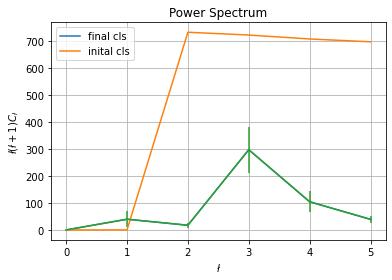

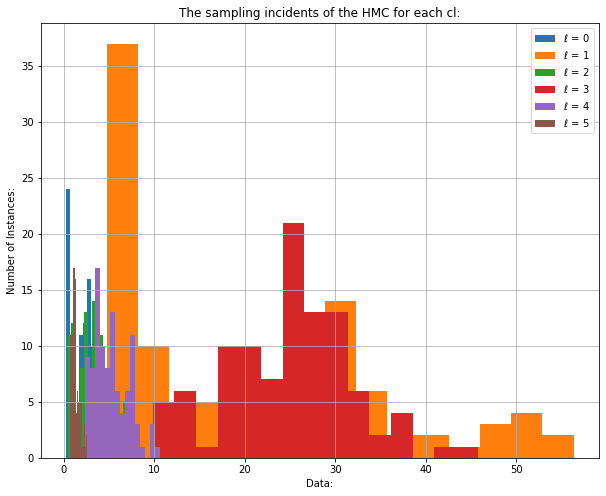

In [87]:
lncl_samples = tf.slice(samples1,[0,0],[100,6]) #The sampled cls from the adaptive step size HMC
cl_samples = tf.math.exp(lncl_samples)
mean_cl = [tf.math.reduce_mean(cl_samples[:,i])  for i in range(lmax4)] #The mean of the sampled cls from the adaptive step size HMC
std_cl = [tf.math.reduce_std(cl_samples[:,i])  for i in range(lmax4)] #The standard deviation of the = sampled cls from the adaptive step size HMC
plt.figure()
plotpwrspctrm(mean_cl) # Plot of the mean sampled cls
plotpwrspctrm(cls4) #Plot of the original cls
ell = np.arange(lmax4)
plt.errorbar(ell,(ell*(ell+1)*mean_cl),xerr = 0, yerr = (ell*(ell+1)*std_cl))
plt.grid()
plt.legend(('final cls','inital cls'))
plt.show()

plt.figure(figsize = [10,8])
[plt.hist((cl_samples[:,i].numpy()), bins = 15) for i in range(lmax4)] #Histogram of the sampled cls for each l value.
plt.legend((r'$\ell$ = 0','$\ell$ = 1','$\ell$ = 2','$\ell$ = 3','$\ell$ = 4','$\ell$ = 5'))
plt.grid()
plt.xlabel('Data:')
plt.ylabel('Number of Instances:')
plt.title('The sampling incidents of the HMC for each cl:')
plt.show()


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will 

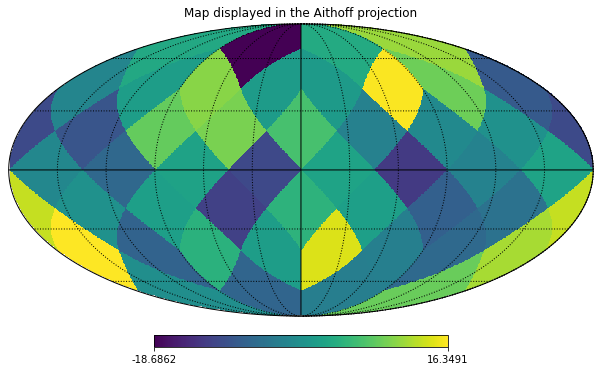

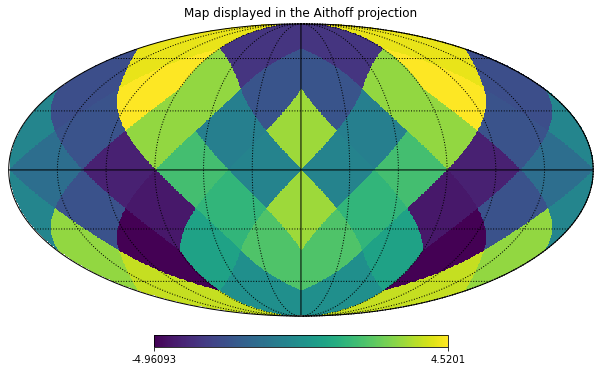

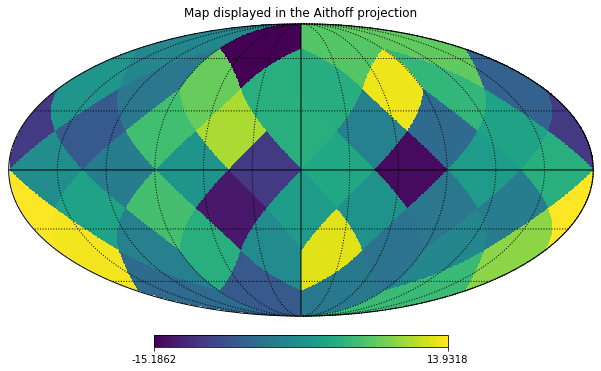

In [89]:
ralm_samples = tf.slice(samples1,[0,6],[100,21]) #The real alm samples from the adaptive step size HMC
ialm_samples = tf.slice(samples1,[0,27],[100,21]) #The imaginary alm samples from the adaptive step size HMC
mean_ralm = [tf.math.reduce_mean(ralm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the real alms
mean_ialm = [tf.math.reduce_mean(ialm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the imaginary alms
std_ralm = [tf.math.reduce_std(ralm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the real alms
std_ialm = [tf.math.reduce_std(ialm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the imaginary alms
mean_alm = splittosingularalm_tf(mean_ralm, mean_ialm) 
mean_map = almtomap_tf(mean_alm,np.int(lmax4/3)) #The mean samples from the HMC as a map

mollviewmap(map4) #Plot of the original map
mollviewmap(mean_map.numpy()) #Plot of the mean samples from the HMC as a map
mollviewmap(map4 - mean_map.numpy()) #A plot of the difference between the original and sampled maps.

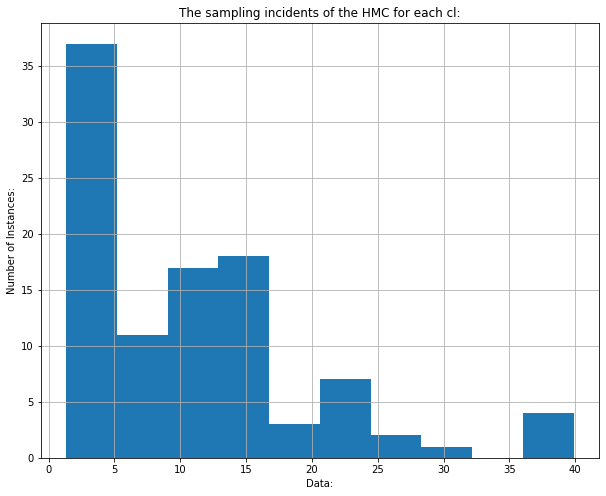

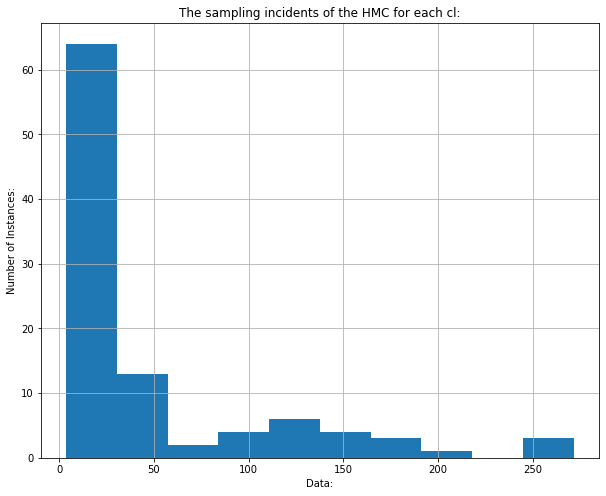

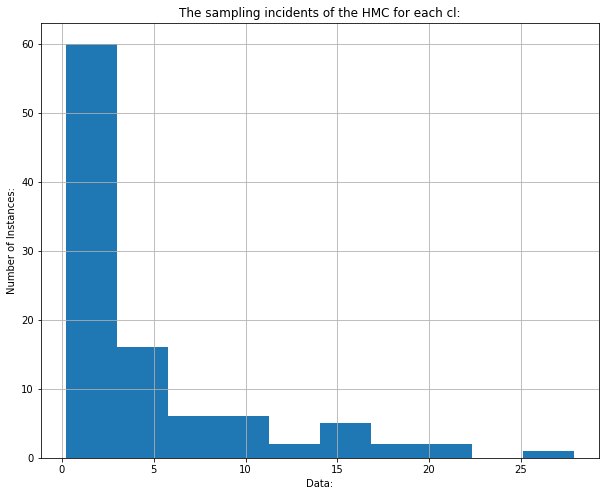

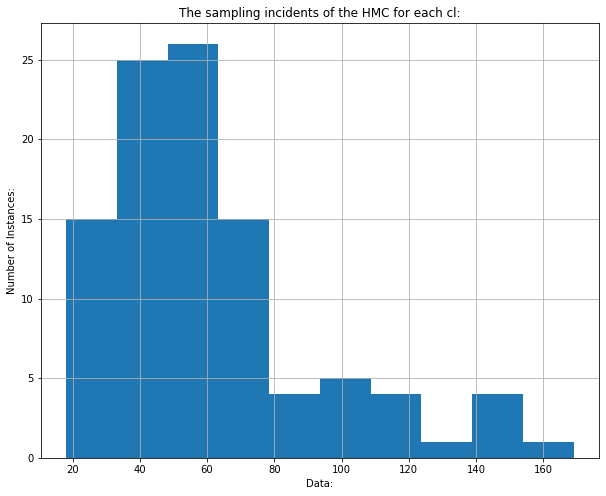

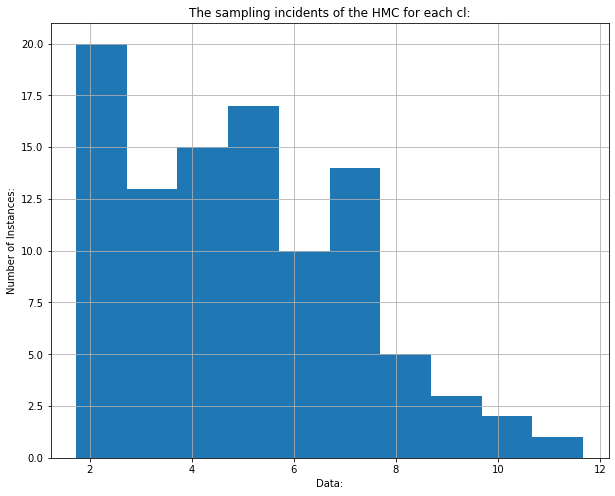

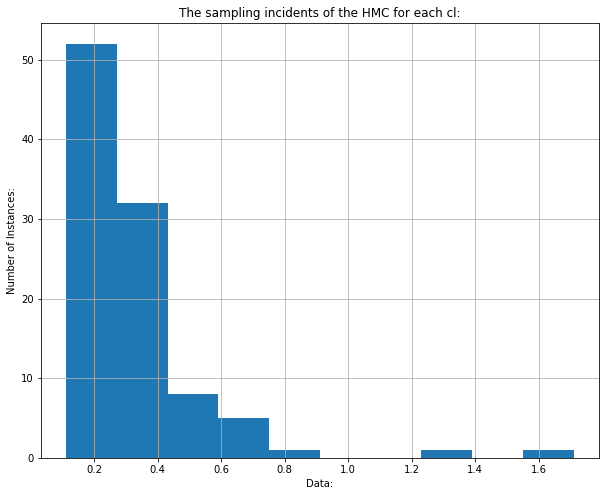

In [134]:
for i in range(lmax4):
    plt.figure(figsize = [10,8])
    plt.hist((cl_samples[:,i].numpy()))  #Histogram of the sampled cls for each l value.
    plt.grid()
    plt.xlabel('Data:')
    plt.ylabel('Number of Instances:')
    plt.title('The sampling incidents of the HMC for each cl:')
    plt.show()

In [ ]:
#[insert here where your maps are coming from]


# loop over samples (what we want!)
#saves the frames:
i = 0
for s in Maps:
    # s[0] is the first bin!
    hp.mollview(s[1][0], min=-0.0115, max=0.0115, title="Bin 2 - $\kappa_1$ ")
    N = str(i).zfill(3)
    plty.savefig(f'/path/to/saving/frames/Kappa_2-frame-{N}.png', bbox_to_inches='tight')
    plty.close()
    i += 1

# Creates the gif:
# filepaths
fp_in = "/path/to/saving/frames/Kappa_2-frame-*.png"
fp_out = "/path/to/saving/gifs/kappa_2.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=80, loop=0, optimize=False)
